<a href="https://colab.research.google.com/github/demelere/CNNs-for-Computer-Vision/blob/master/458_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

Model | Loss | Accuracy | Val Loss | Val Accuracy | Training | Testing
--- | --- | --- | --- | --- | --- | --- 
DNN (2 layers no dropout) | Row 1, Col 2 | 
DNN (3 layers no dropout) | Row 2, Col 2 |
CNN (2 layers no dropout) | Row 2, Col 2 |
CNN (2 layers no dropout) | Row 2, Col 2 |

Model | Loss | Accuracy | Val Loss | Val Accuracy | Training | Testing
--- | --- | --- | --- | --- | --- | --- 
DNN (2 layers w/dropout) | Row 1, Col 2 | 
DNN (3 layers w/dropout) | Row 2, Col 2 |
CNN (2 layers w/dropout) | Row 2, Col 2 |
CNN (2 layers w/dropout) | Row 2, Col 2 |

Parameters for all models: 
* Batch size = 100
* Epochs = 20
* Loss function = sparse categorical cross-entropy
* Optimizer = Adam

# A. Setup and Import

In [2]:
# Import dependencies
import numpy as np
import pandas as pd
import os
from collections import Counter
import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# check Keras version
keras.__version__

# check tensorflow version
tf.__version__

# set seed
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
# Saving in Colab
# os.getcwd()
# %cd /content/gdrive/My\ Drive/MSDS458/weekfive
# !pwd
# !ls
# print('Working Directory')
# print(os.getcwd())
# work_dir = "content/gdrive/My Drive/MSDS458/weekfive"
# chp_id = "ann"

## A.1 Import data

In [6]:
from tensorflow.keras.datasets import fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images.shape, test_images.shape, test_labels.shape, test_labels.shape

4423680/4422102 [==============================] - 0s 0us/step


((60000, 28, 28), (10000, 28, 28), (10000,), (10000,))

In [7]:
# training labels are integers btw/0 and 9, and correspond to different articles of clothing
Counter(train_labels).most_common()

[(9, 6000),
 (0, 6000),
 (3, 6000),
 (2, 6000),
 (7, 6000),
 (5, 6000),
 (1, 6000),
 (6, 6000),
 (4, 6000),
 (8, 6000)]

In [8]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

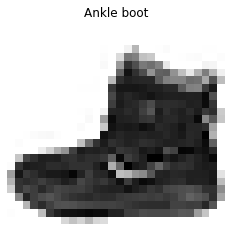

In [9]:
# example of training image
plt.imshow(train_images[0], cmap="binary") 
plt.axis('off')
plt.title(class_names[test_labels[0]], fontsize=12)
plt.show()

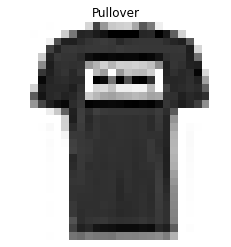

In [10]:
# example of training image
plt.imshow(train_images[1], cmap="binary") 
plt.axis('off')
plt.title(class_names[test_labels[1]], fontsize=12)
plt.show()

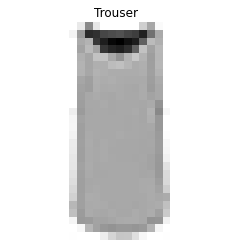

In [11]:
# example of training image
plt.imshow(train_images[2], cmap="binary") 
plt.axis('off')
plt.title(class_names[test_labels[2]], fontsize=12)
plt.show()

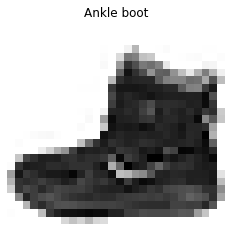

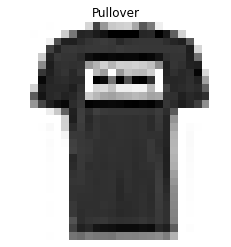

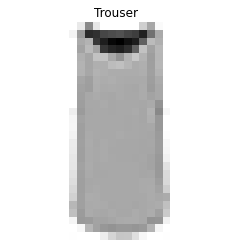

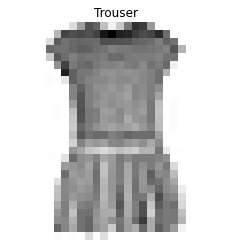

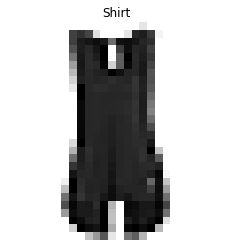

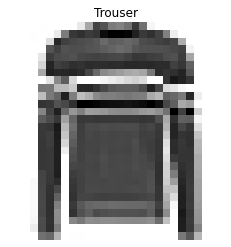

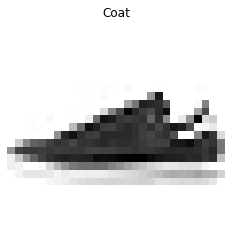

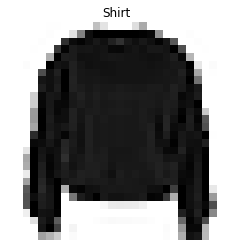

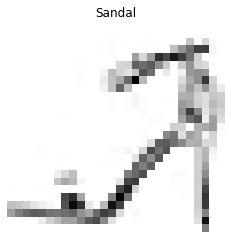

In [12]:
for i in range (9):
  plt.imshow(train_images[i], cmap="binary") 
  plt.axis('off')
  plt.title(class_names[test_labels[i]], fontsize=12)
  plt.show()
  

## A.2 Data Cleaning and Transformation

In [13]:
# Reshape the data into the right format for model (float32 array w/shape 60000, 28*28 and values btw/ 0 and 1).
#train_images = train_images.reshape((60000, 28 * 28))  # Decided instead to use a Flatten layer in the model
train_images = train_images.astype('float32') / 255

#test_images = test_images.reshape((10000, 28 * 28))  # Decided instead to use a Flatten layer in the model
test_images = test_images.astype('float32') / 255

In [14]:
# Hold back 5,000 of the 60,000 training images for validation.
val_images, train_images = train_images[:5000], train_images[5000:] 
val_labels, train_labels = train_labels[:5000], train_labels[5000:]

In [15]:
# function to help calculate training and test evaluation times
class TrainRuntimeCallback(keras.callbacks.Callback):

  def on_train_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_train_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

In [16]:
class TestRuntimeCallback(keras.callbacks.Callback):

  def on_test_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_test_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

# 1. Experiment 1: Baseline DNN w/2 layers

This model will have 784 input nodes.  It will take two dense (fully-connected) layers.  The first (hidden) layer will have 5 nodes, and the second (softmax) layer will have 10 output nodes.

In [17]:
model_1 = models.Sequential()
model_1.add(layers.Flatten(input_shape=[28, 28]))
model_1.add(layers.Dense(5, activation='relu'))
model_1.add(layers.Dense(10, activation='softmax')) 

In [18]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 3925      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                60        
Total params: 3,985
Trainable params: 3,985
Non-trainable params: 0
_________________________________________________________________


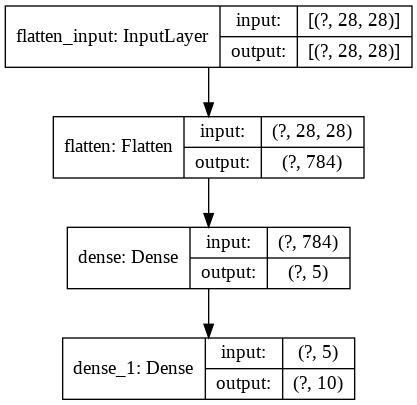

In [19]:
keras.utils.plot_model(model_1, show_shapes=True)

## 1A. Model Compilation

This step includes an optimizer (how the network updates itself based on the data and the loss function), a loss function (how the network measures how good a job it is doing on the data and adjusts), and metrics (accuracy).

In [20]:
model_1.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

## 1B. Model Training

Train model for 20 epochs with batch size 100

In [21]:
train_rt = TrainRuntimeCallback()
history = model_1.fit(train_images, train_labels, callbacks=[train_rt], epochs=20, batch_size=100,
                    validation_data=(val_images, val_labels))

# Saving models locally after fitting
save_dir = "results/"
model_name = 'fashion_mnist_model_1.h5'
model_path = os.path.join(save_dir, model_name)
print('--------------------------')

Epoch 1/20
550/550 [==============================] - 1s 3ms/step - loss: 1.5333 - accuracy: 0.5120 - val_loss: 1.0563 - val_accuracy: 0.7034
Epoch 2/20
550/550 [==============================] - 1s 2ms/step - loss: 0.8434 - accuracy: 0.7454 - val_loss: 0.6535 - val_accuracy: 0.7846
Epoch 3/20
550/550 [==============================] - 1s 2ms/step - loss: 0.6183 - accuracy: 0.7958 - val_loss: 0.5835 - val_accuracy: 0.8096
Epoch 4/20
550/550 [==============================] - 1s 2ms/step - loss: 0.5639 - accuracy: 0.8114 - val_loss: 0.5502 - val_accuracy: 0.8138
Epoch 5/20
550/550 [==============================] - 1s 2ms/step - loss: 0.5399 - accuracy: 0.8178 - val_loss: 0.5279 - val_accuracy: 0.8230
Epoch 6/20
550/550 [==============================] - 1s 2ms/step - loss: 0.5250 - accuracy: 0.8205 - val_loss: 0.5145 - val_accuracy: 0.8288
Epoch 7/20
550/550 [==============================] - 1s 2ms/step - loss: 0.5135 - accuracy: 0.8244 - val_loss: 0.5108 - val_accuracy: 0.8294
Epoch 

In [22]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

26.291443

In [23]:
model_1.layers[1].weights

[<tf.Variable 'dense/kernel:0' shape=(784, 5) dtype=float32, numpy=
 array([[-0.08495625, -0.02450575,  0.5867726 , -0.18403265, -0.30403847],
        [-0.13381931,  0.01560646,  0.09165865, -0.07803686,  0.00608766],
        [ 0.39040858, -0.4066511 , -0.4757636 , -0.48878846, -0.10543991],
        ...,
        [ 0.4744351 ,  0.41354445,  0.10598992, -0.03145837,  0.23590438],
        [ 0.00998982,  0.60049945, -0.11730633, -0.19239654,  0.39222446],
        [ 0.07808983,  0.431397  ,  0.2116207 , -0.48969564,  0.10832103]],
       dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(5,) dtype=float32, numpy=
 array([ 1.0045774 ,  0.8961467 ,  0.67530763,  0.9230627 , -0.32683724],
       dtype=float32)>]

## 1C. Model Testing

Test the model on the test dataset.

In [24]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model_1.evaluate(test_images, test_labels, callbacks=[test_rt])

313/313 [==============================] - 1s 2ms/step - loss: 0.5112 - accuracy: 0.8244


In [25]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.634644

In [26]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [27]:
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.472350,0.834200,0.484858,0.8346
16,0.469477,0.835364,0.490041,0.8330
17,0.467037,0.837309,0.485983,0.8356
18,0.466209,0.837127,0.487460,0.8384
19,0.463785,0.837818,0.485111,0.8342


In [28]:
# Create a results DataFrame using the last row of history_df
results_df = history_df.iloc[-1:].copy()
results_df.insert(0,'model','DNN (2 layers)') # went the model name to appear first
results_df['training time (sec)'] = train_time      # we are okay with training time appearing last
results_df['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df

,model,loss,accuracy,val_loss,val_accuracy,training time (sec),testing time (sec)
19,DNN (2 layers),0.463785,0.837818,0.485111,0.8342,26.291443,0.634644


## 1D. Performance

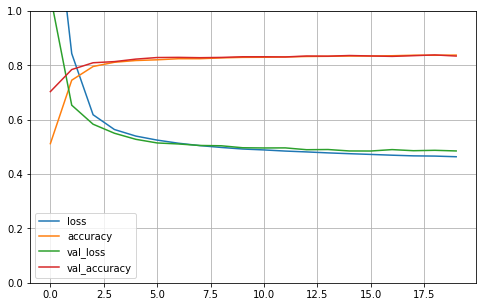

In [29]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

# 2. Experiment 2: DNN w/3 layers

This model will have 784 input nodes.  It will take three dense (fully-connected) layers.  The first (hidden) layer will have 10 nodes, a second hidden layer with 10 nodes, and a third (softmax) layer will have 10 output nodes.

In [30]:
# Instead of adding the layers one by one, we can pass a list of layers when creating the Sequential mode.
model_2 = models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(5, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [31]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                7850      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_4 (Dense)              (None, 10)                60        
Total params: 7,965
Trainable params: 7,965
Non-trainable params: 0
_________________________________________________________________


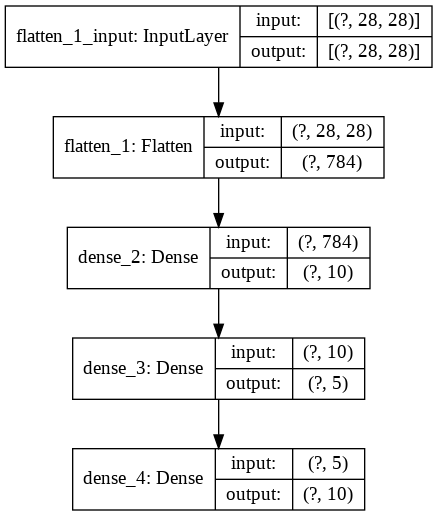

In [32]:
keras.utils.plot_model(model_2, show_shapes=True)

## 2A. Model Compilation

In [33]:
model_2.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

## 2B. Model Training


In [34]:
train_rt = TrainRuntimeCallback()
history = model_2.fit(train_images, train_labels, callbacks=[train_rt], epochs=20, batch_size = 100,
                    validation_data=(val_images, val_labels))

# Saving models locally after fitting
save_dir = "results/"
model_name = 'fashion_mnist_model_2.h5'
model_path = os.path.join(save_dir, model_name)
print('--------------------------')

Epoch 1/20
550/550 [==============================] - 1s 2ms/step - loss: 1.0934 - accuracy: 0.6273 - val_loss: 0.6276 - val_accuracy: 0.7880
Epoch 2/20
550/550 [==============================] - 1s 2ms/step - loss: 0.5943 - accuracy: 0.7963 - val_loss: 0.5267 - val_accuracy: 0.8194
Epoch 3/20
550/550 [==============================] - 1s 2ms/step - loss: 0.5254 - accuracy: 0.8206 - val_loss: 0.5050 - val_accuracy: 0.8320
Epoch 4/20
550/550 [==============================] - 1s 2ms/step - loss: 0.4917 - accuracy: 0.8315 - val_loss: 0.4757 - val_accuracy: 0.8402
Epoch 5/20
550/550 [==============================] - 1s 2ms/step - loss: 0.4727 - accuracy: 0.8371 - val_loss: 0.4547 - val_accuracy: 0.8458
Epoch 6/20
550/550 [==============================] - 1s 2ms/step - loss: 0.4590 - accuracy: 0.8415 - val_loss: 0.4435 - val_accuracy: 0.8494
Epoch 7/20
550/550 [==============================] - 1s 2ms/step - loss: 0.4444 - accuracy: 0.8459 - val_loss: 0.4326 - val_accuracy: 0.8546
Epoch 

In [35]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

25.534299

In [36]:
model_2.layers[1].weights

[<tf.Variable 'dense_2/kernel:0' shape=(784, 10) dtype=float32, numpy=
 array([[ 0.4925621 ,  0.04878267, -0.47940648, ...,  0.28546274,
         -0.38828492, -0.02152865],
        [ 0.5183464 ,  0.25312173,  0.5069263 , ..., -0.2122109 ,
         -0.65054905,  0.34231693],
        [ 0.18238327, -0.1502212 , -0.2130859 , ...,  0.27302274,
         -0.69527584, -0.1994194 ],
        ...,
        [-0.23606896, -0.13785227,  0.06954484, ..., -0.06773212,
          0.23245028,  0.42269328],
        [ 0.42236978, -0.762525  , -0.14763372, ...,  0.2259654 ,
          0.25379887,  0.16036195],
        [ 0.21001172, -0.11549312, -0.16125627, ...,  0.2857493 ,
         -0.25067648, -0.07645933]], dtype=float32)>,
 <tf.Variable 'dense_2/bias:0' shape=(10,) dtype=float32, numpy=
 array([ 0.3373559 ,  0.40660846, -0.00816518,  0.27010486, -0.31941098,
         0.47647446, -0.01031993, -0.13826925, -0.25403666,  0.6022843 ],
       dtype=float32)>]

## 2C. Model Compilation

In [37]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model_2.evaluate(test_images, test_labels, callbacks=[test_rt])

313/313 [==============================] - 1s 2ms/step - loss: 0.4404 - accuracy: 0.8490


In [38]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.760157

In [39]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [40]:
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.394387,0.863873,0.421012,0.8582
16,0.391197,0.863582,0.402562,0.8682
17,0.388530,0.865491,0.400487,0.8686
18,0.387732,0.865745,0.407128,0.8646
19,0.385630,0.865982,0.401313,0.8648


In [41]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
results_df2 = history_df.iloc[-1:].copy()
results_df2.insert(0,'model','DNN (3 layers)') # went the model name to appear first
results_df2['training time (sec)'] = train_time      # we are okay with training time appearing last
results_df2['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df2

,model,loss,accuracy,val_loss,val_accuracy,training time (sec),testing time (sec)
19,DNN (3 layers),0.38563,0.865982,0.401313,0.8648,25.534299,0.760157


In [42]:
# # Add the new data to results_df
# results_df=results_df.append(results_df2,ignore_index=True)
# results_df

## 2D. Performance

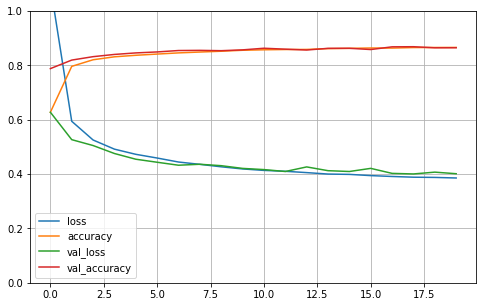

In [43]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

# 3. Experiment 3: CNN w/2 layers

This model will have 2 layers, each consisting of a convolution layer and a max pooling layer.  The second layer will return an array of 10 probability scores.

In [44]:
# Data re-import and preparation
from tensorflow.keras.datasets import fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images.shape, test_images.shape, test_labels.shape, test_labels.shape

((60000, 28, 28), (10000, 28, 28), (10000,), (10000,))

In [45]:
# Reshape images and scale
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

In [46]:
# Validation images
val_images, train_images = train_images[:5000], train_images[5000:] 
val_labels, train_labels = train_labels[:5000], train_labels[5000:]

In [47]:
model_3a = models.Sequential()
model_3a.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_3a.add(layers.MaxPooling2D((2, 2)))
model_3a.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_3a.add(layers.MaxPooling2D((2, 2)))
model_3a.add(layers.Flatten())
model_3a.add(layers.Dense(128, activation='relu'))
model_3a.add(layers.Dense(10, activation='softmax'))

In [48]:
model_3a.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               204928    
_________________________________________________________________
dense_6 (Dense)              (None, 10)               

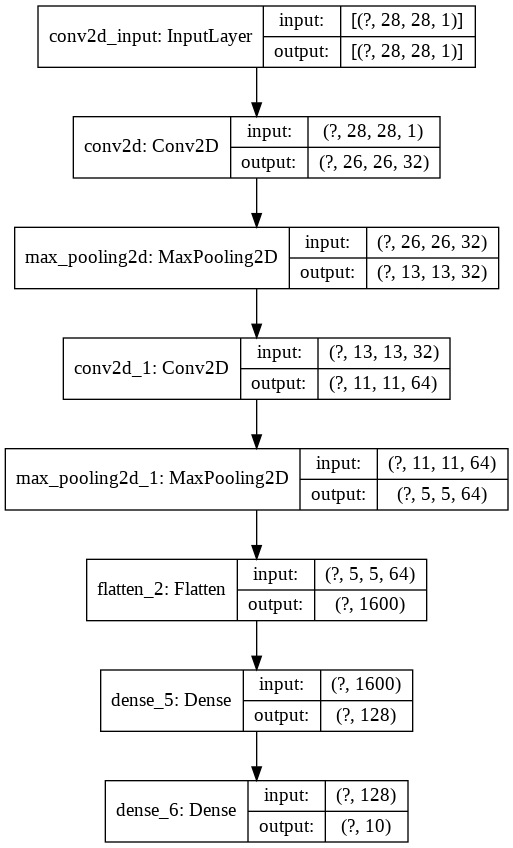

In [49]:
keras.utils.plot_model(model_3a, show_shapes=True)

## 3A. Model Compilation

In [50]:
model_3a.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

## 3B. Model Training

In [51]:
train_rt = TrainRuntimeCallback()
history = model_3a.fit(train_images, train_labels, callbacks=[train_rt], epochs=20, batch_size = 100,
                    validation_data=(val_images, val_labels))

# Saving models locally after fitting
save_dir = "results/"
model_name = 'fashion_mnist_model_3a.h5'
model_path = os.path.join(save_dir, model_name)
print('--------------------------')

Epoch 1/20
550/550 [==============================] - 2s 4ms/step - loss: 0.5366 - accuracy: 0.8075 - val_loss: 0.3788 - val_accuracy: 0.8640
Epoch 2/20
550/550 [==============================] - 2s 3ms/step - loss: 0.3483 - accuracy: 0.8751 - val_loss: 0.3169 - val_accuracy: 0.8868
Epoch 3/20
550/550 [==============================] - 2s 3ms/step - loss: 0.3028 - accuracy: 0.8899 - val_loss: 0.2966 - val_accuracy: 0.8928
Epoch 4/20
550/550 [==============================] - 2s 3ms/step - loss: 0.2683 - accuracy: 0.9018 - val_loss: 0.2772 - val_accuracy: 0.9002
Epoch 5/20
550/550 [==============================] - 2s 3ms/step - loss: 0.2456 - accuracy: 0.9111 - val_loss: 0.2548 - val_accuracy: 0.9092
Epoch 6/20
550/550 [==============================] - 2s 3ms/step - loss: 0.2265 - accuracy: 0.9175 - val_loss: 0.2474 - val_accuracy: 0.9070
Epoch 7/20
550/550 [==============================] - 2s 3ms/step - loss: 0.2074 - accuracy: 0.9231 - val_loss: 0.2339 - val_accuracy: 0.9148
Epoch 

In [52]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

42.654665

## 3C. Model Testing

Evaluate the model on the test dataset using a callback to get the total test time.

In [53]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model_3a.evaluate(test_images, test_labels, callbacks=[test_rt])

313/313 [==============================] - 1s 2ms/step - loss: 0.3309 - accuracy: 0.9128


In [54]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.856157

In [55]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [56]:
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.094811,0.965255,0.280224,0.9144
16,0.085593,0.968491,0.272949,0.9172
17,0.075359,0.972527,0.292871,0.9162
18,0.071219,0.974182,0.324832,0.9118
19,0.061248,0.978055,0.302873,0.9180


In [57]:
# Pull statistics 
results_df3a = history_df.iloc[-1:].copy()
results_df3a.insert(0,'model','CNN (2 layers)') # want the model name to appear first
results_df3a['training time (sec)'] = train_time      # we are okay with training time appearing last
results_df3a['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df3a

,model,loss,accuracy,val_loss,val_accuracy,training time (sec),testing time (sec)
19,CNN (2 layers),0.061248,0.978055,0.302873,0.918,42.654665,0.856157


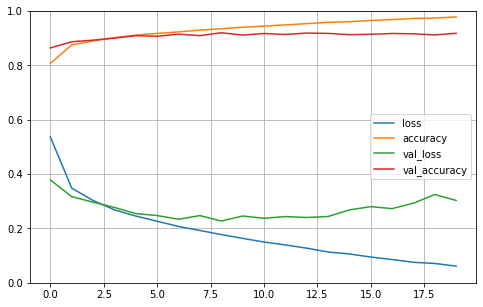

In [58]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

# 4. Experiment 4: CNN w/3 layers
We create a `CNN` with 3 convolution/max pooling layers (**no drop out**) to work with our Fashion MNIST dataset. The experiment compares performance using L2 regularization in the convolutional layers. Image augmentation is not employed.

## Model 4a: baseline CNN with 3 layers (no L2 regularization)

In [59]:
model_4a = models.Sequential()
model_4a.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_4a.add(layers.MaxPooling2D((2, 2)))
model_4a.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_4a.add(layers.MaxPooling2D((2, 2)))
model_4a.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_4a.add(layers.Flatten())
model_4a.add(layers.Dense(64, activation='relu'))
model_4a.add(layers.Dense(10, activation='softmax'))

In [60]:
model_4a.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)               

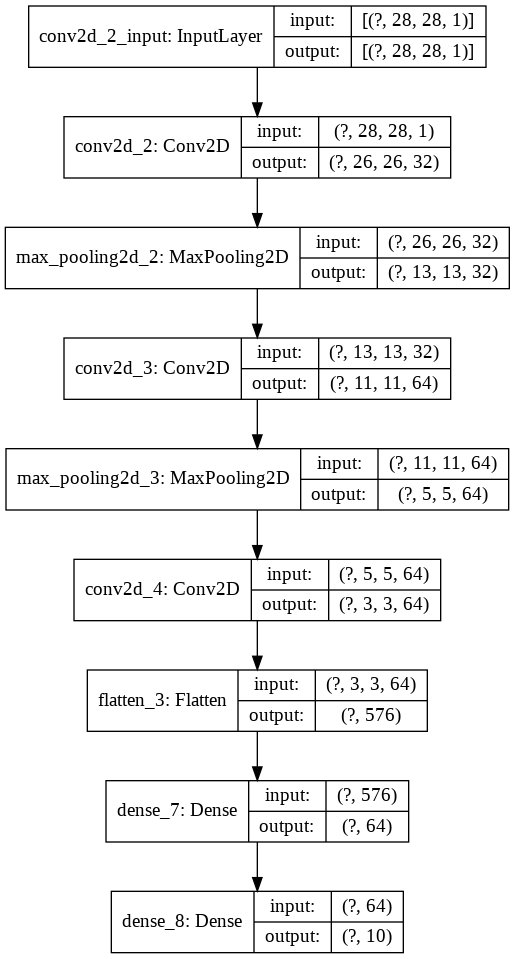

In [61]:
keras.utils.plot_model(model_4a, show_shapes=True)

## 4A. Model Compilation

In [62]:
model_4a.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

## 4B. Model Compilation

In [63]:
train_rt = TrainRuntimeCallback()
history = model_4a.fit(train_images, train_labels, callbacks=[train_rt], epochs=20, batch_size = 100,
                    validation_data=(val_images, val_labels))

# Saving models locally after fitting
save_dir = "results/"
model_name = 'fashion_mnist_model_4a.h5'
model_path = os.path.join(save_dir, model_name)
print('--------------------------')

Epoch 1/20
550/550 [==============================] - 2s 4ms/step - loss: 0.5839 - accuracy: 0.7873 - val_loss: 0.3805 - val_accuracy: 0.8660
Epoch 2/20
550/550 [==============================] - 2s 4ms/step - loss: 0.3630 - accuracy: 0.8678 - val_loss: 0.3182 - val_accuracy: 0.8850
Epoch 3/20
550/550 [==============================] - 2s 3ms/step - loss: 0.3109 - accuracy: 0.8861 - val_loss: 0.3021 - val_accuracy: 0.8902
Epoch 4/20
550/550 [==============================] - 2s 3ms/step - loss: 0.2804 - accuracy: 0.8971 - val_loss: 0.2674 - val_accuracy: 0.9024
Epoch 5/20
550/550 [==============================] - 2s 4ms/step - loss: 0.2559 - accuracy: 0.9056 - val_loss: 0.2584 - val_accuracy: 0.9048
Epoch 6/20
550/550 [==============================] - 2s 4ms/step - loss: 0.2388 - accuracy: 0.9116 - val_loss: 0.2590 - val_accuracy: 0.9022
Epoch 7/20
550/550 [==============================] - 2s 4ms/step - loss: 0.2180 - accuracy: 0.9193 - val_loss: 0.2410 - val_accuracy: 0.9092
Epoch 

In [64]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

39.695646

## 4C. Model Testing

In [65]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model_4a.evaluate(test_images, test_labels, callbacks=[test_rt])

313/313 [==============================] - 1s 2ms/step - loss: 0.3388 - accuracy: 0.9042


In [66]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.773794

In [67]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [68]:
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.110460,0.959455,0.280067,0.9180
16,0.102719,0.961855,0.283918,0.9166
17,0.092769,0.965309,0.298722,0.9166
18,0.086586,0.967655,0.302397,0.9158
19,0.076909,0.971745,0.316066,0.9076


In [69]:
# Pull statistics 
# Pull statistics 
results_df4a = history_df.iloc[-1:].copy()
results_df4a.insert(0,'model','CNN (3 layers)') # want the model name to appear first
results_df4a['training time (sec)'] = train_time      # we are okay with training time appearing last
results_df4a['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df4a

,model,loss,accuracy,val_loss,val_accuracy,training time (sec),testing time (sec)
19,CNN (3 layers),0.076909,0.971745,0.316066,0.9076,39.695646,0.773794


In [70]:
# Combine with previous results
# prev_results_df = pd.read_pickle('results.pkl')
# results_df = results_df.append(results_df3a,ignore_index=True)
# results_df = results_df.append(results_df3b,ignore_index=True)
# results_df

## Plot the performance 

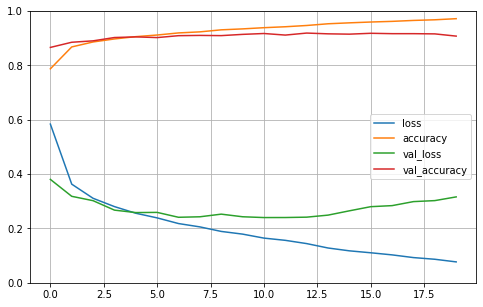

In [71]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()